Code to (re)produce results in the paper 
"Manipulating the Online Marketplace of Ideas" 
by Xiaodan Lou, Alessandro Flammini, and Filippo Menczer
https://arxiv.org/abs/1907.06130

Notes:
* Need Python 3.6 or later; eg: `module load python/3.6.6`
* Remember link direction is following, opposite of info spread!
* For large `n_humans`, it's much faster to run the simulations in parallel on a server or cluster, eg, one process for each combination of parameters (gamma, phi, mu...)


Parameters and default values:
```
n_humans = 1000 # 10k for paper
beta = 0.1 # bots/humans ratio; 0.1 for paper
p = 0.5 # for network clustering; 0.5 for paper
k_out = 3 # average no. friends within humans & bots; 3 for paper
alpha = 15 # depth of feed; 15 for paper
mu = 0.75 # average prob of new meme vs retweet; 0.75 for paper or draw from empirical distribution
phi = 1 # bot deception >= 1: meme fitness higher than quality
gamma = 0.1 # infiltration: probability that a human follows each bot
epsilon = 0.01 # threshold used to check for steady-state convergence
n_runs = 10 # or 20? number of simulations to average results
csvfile = 'results.csv' # to save results for plotting
```

In [1]:
import networkx as nx
import random
import numpy
import math
import statistics
import csv
import matplotlib.pyplot as plt
from operator import itemgetter
import sys
import fcntl
import time
import bot_model

%matplotlib inline
assert(nx.__version__ >= '2.4')

# Supplementary tests and analyses

In [0]:
# TEST NO BOTS

av_q, G_no_bots = bot_model.simulation(False, return_net=True, beta = 0.0, gamma = 0.0)
nx.write_gml(bot_model.add_avq_to_net(G_no_bots),'G_no_bots.gml')
print("Average quality without bots:", av_q)

Average quality without bots: 0.3747455709536642


In [0]:
# test Gini concentration of zeros

for gamma in [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0]: 
  _, G = bot_model.simulation(False, return_net=True, gamma=gamma)
  gini_coefficient_random = bot_model.gini(G)
  print("random targeting, gamma =", gamma, ": Gini =", gini_coefficient_random)
  _, G = bot_model.simulation(True, return_net=True, gamma=gamma)
  gini_coefficient_prefer = bot_model.gini(G)
  print("prefer targeting, gamma =", gamma, ": Gini =", gini_coefficient_prefer)
  print("prefer targeting, gamma =", gamma, ": Gini diff=", gini_coefficient_prefer-gini_coefficient_random)

random targeting, gamma = 0.001 : Gini = 0.07187730061349694
prefer targeting, gamma = 0.001 : Gini = 0.39587786259541985
prefer targeting, gamma = 0.001 : Gini diff= 0.3240005619819229
random targeting, gamma = 0.005 : Gini = -0.03218768328445748
prefer targeting, gamma = 0.005 : Gini = 0.3952098385857033
prefer targeting, gamma = 0.005 : Gini diff= 0.4273975218701608
random targeting, gamma = 0.01 : Gini = 0.002804363814660456
prefer targeting, gamma = 0.01 : Gini = 0.3486406487582362
prefer targeting, gamma = 0.01 : Gini diff= 0.3458362849435757
random targeting, gamma = 0.05 : Gini = -0.0023609547836211916
prefer targeting, gamma = 0.05 : Gini = 0.28871819166215484
prefer targeting, gamma = 0.05 : Gini diff= 0.29107914644577604
random targeting, gamma = 0.1 : Gini = 0.006267171800362378
prefer targeting, gamma = 0.1 : Gini = 0.25482084217580697
prefer targeting, gamma = 0.1 : Gini diff= 0.2485536703754446
random targeting, gamma = 0.5 : Gini = -0.0003630165576735773
prefer targetin

In [0]:
# STEPWISE TEST INIT

network = bot_model.init_net(True) # only once!

In [0]:
# STEPWISE TEST STEP

bot_model.simulation_step(network)
print("prefer targeting: average quality =", bot_model.measure_average_quality(network))
for agent in network.nodes:
  if network.nodes[agent]['bot'] == False:
    print('human feed:', ["{0:.2f}".format(round(m[0], 2)) for m in network.nodes[agent]['feed']])

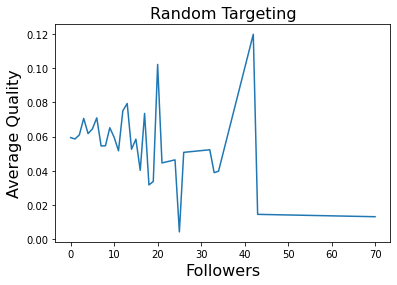

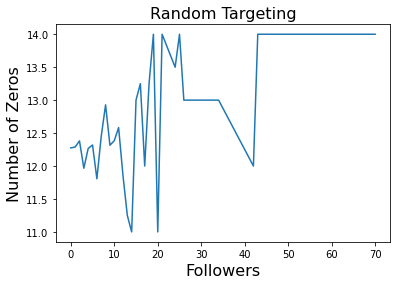

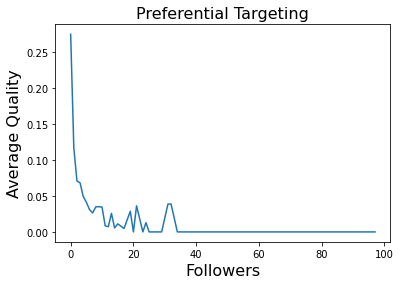

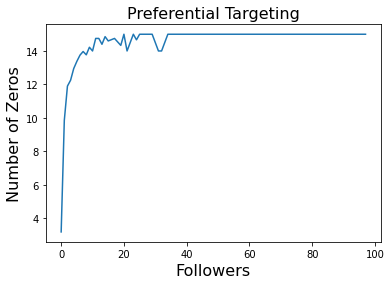

In [0]:
# exp for relationship between indegree and low-quality in humans

# gamma = 0.1
(avg_q, G) = bot_model.simulation(False, return_net=True, gamma = 0.1) 
(avg_quality, n_zeros) = bot_model.quality_vs_degree(G)
bot_model.plot_quantity_vs_degree('Random Targeting', 'Average Quality', avg_quality)
bot_model.plot_quantity_vs_degree('Random Targeting', 'Number of Zeros', n_zeros)
(avg_q, G) = bot_model.simulation(True, return_net=True, gamma = 0.1)
(avg_quality, n_zeros) = bot_model.quality_vs_degree(G)
bot_model.plot_quantity_vs_degree('Preferential Targeting', 'Average Quality', avg_quality)
bot_model.plot_quantity_vs_degree('Preferential Targeting', 'Number of Zeros', n_zeros)

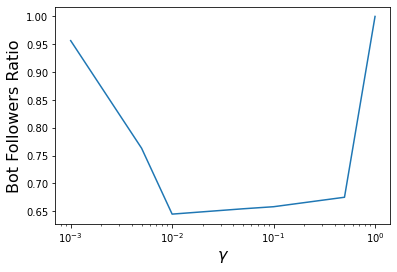

In [0]:
# exp to see how the number of bot followers depends on gamma 

victims_ratio = {}
for gamma in [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0]: 
  net_pref = bot_model.init_net(True, gamma=gamma)
  net_rand = bot_model.init_net(False, gamma=gamma)
  victims_ratio[gamma] = bot_model.bot_followers(net_pref) / bot_model.bot_followers(net_rand)
plt.xlabel(r'$\gamma$', fontsize=16)
plt.ylabel('Bot Followers Ratio', fontsize=16)
plt.xscale('log')
plt.plot(list(victims_ratio.keys()), list(victims_ratio.values()))

In [0]:
# exp for forgotten zero-quality memes in humans
# and relationship with indegree  

#gamma = 0.5
n_zeros_forgotten_random = []
n_zeros_forgotten_prefer = []

for _ in range(n_runs):
  bot_model.forgotten_memes_per_degree.forgotten_memes = {}
  bot_model.simulation(False, count_forgotten=True, gamma = 0.5) 
  #print('Random Targeting:', sum(bot_model.forgotten_memes_per_degree.forgotten_memes.values()), 'low-quality memes forgotten')
  n_zeros_forgotten_random.append(sum(bot_model.forgotten_memes_per_degree.forgotten_memes.values()))

  bot_model.forgotten_memes_per_degree.forgotten_memes = {}
  bot_model.simulation(True, count_forgotten=True, gamma = 0.5)
  #print('Preferential Targeting:', sum(bot_model.forgotten_memes_per_degree.forgotten_memes.values()), 'low-quality memes forgotten')
  n_zeros_forgotten_prefer.append(sum(bot_model.forgotten_memes_per_degree.forgotten_memes.values()))

print('Random Targeting:', statistics.mean(n_zeros_forgotten_random), '+/-', statistics.stdev(n_zeros_forgotten_random) / math.sqrt(n_runs), 'low-quality memes forgotten')
print('Preferential Targeting:', statistics.mean(n_zeros_forgotten_prefer), '+/-', statistics.stdev(n_zeros_forgotten_prefer) / math.sqrt(n_runs), 'low-quality memes forgotten')

Random Targeting: 2324401.75 +/- 680214.625023598 low-quality memes forgotten
Preferential Targeting: 482222.75 +/- 45017.67565739127 low-quality memes forgotten


gamma = 0.01
gamma = 0.02
gamma = 0.03
gamma = 0.04
gamma = 0.05


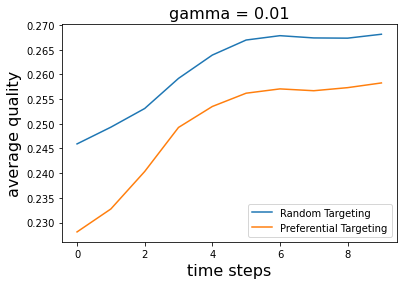

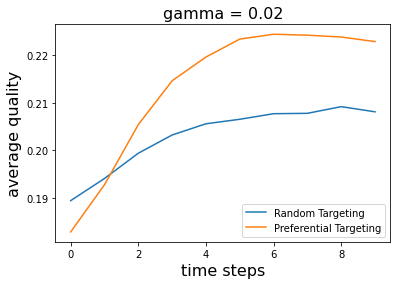

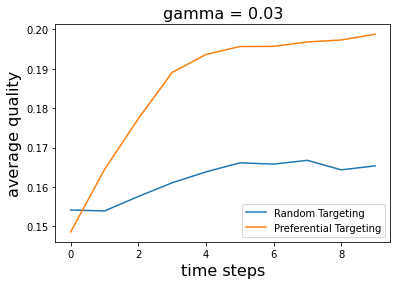

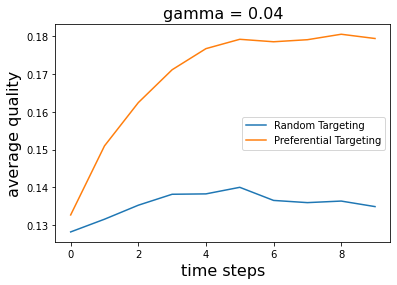

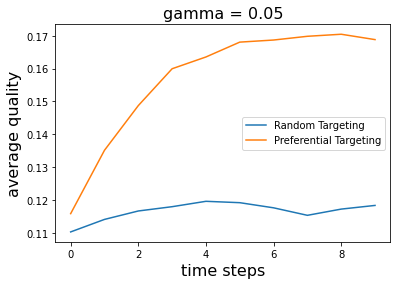

In [0]:
# experiment plotting quality over time

for gamma in [0.01, 0.02, 0.03, 0.04, 0.05]: 
  print('gamma =', gamma)
  plt.figure()
  plt.xlabel('time steps', fontsize=16)
  plt.ylabel('average quality', fontsize=16)
  plt.title('gamma = ' + str(gamma), fontsize=16)
  timeline_random = bot_model.simulation_timeline(False, gamma=gamma)
  timeline_prefer = bot_model.simulation_timeline(True, gamma=gamma)
  plt.plot(timeline_random, label='Random Targeting')
  plt.plot(timeline_prefer, label='Preferential Targeting')
  plt.legend()